# Название проекта: Прогнозирование временного ряда в трейдинге криптовалют.

# Описание проекта, задача, цель.
    На основе исторических данных криптовалютной биржы Binance
    на примере BTCBUSD (бессрочный контракт Binance Futures)
    предскажем изменение тренда фьючерса на заданное количество периодов (временных интервалов свеч) вперед.

# Загрузка библиотек, данных.

In [ ]:
%%time

#установка библиотек
!pip install catboost
!pip install python-binance

!pip install TA-Lib # if that doesn't work in colab - then try this:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [ ]:
#импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st

#хитмэп корреляции
import os
import seaborn as sns #построение графиков

#операции с выборкой
from sklearn.model_selection import train_test_split

#сохранение модели
import joblib 
from joblib import dump

#классификация
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

#регрессия
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor #создание константной модели (среднее, медиана и др)

#преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#метрики
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score #кросс-валидация
from sklearn.metrics import make_scorer #для написания ручной оценки

#подбор параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#построение ROC-кривой
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

#раздел upsampling
from sklearn.utils import shuffle

#библиотека LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor

#библиотека CatBoost
import catboost as cb
from catboost import CatBoostRegressor

#разложение временного ряда на тренд и сезонную компоненту, построение графиков этих составляющих ряда
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#замена стандартной кросс-валидации для временных рядов
from sklearn.model_selection import TimeSeriesSplit

#для графиков
import pylab
#plt.style.use('ggplot')

# показывать все столбцы вместо [...]
pd.set_option('max_columns', None)

# для увеличения значения ячеев со временем
from datetime import datetime,timedelta

from binance.client import Client
import matplotlib.pyplot as plt
import pandas as pd

#разложение временного ряда на тренд и сезонную компоненту, построение графиков этих составляющих ряда
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#замена стандартной кросс-валидации для временных рядов
from sklearn.model_selection import TimeSeriesSplit

#для графиков
import pylab
#plt.style.use('ggplot')
# https://bablofil.com/python-indicators/

import numpy
import talib as tb
import requests
import json
import time

#from matplotlib.finance import candlestick2_ohlc - не нашел установщик такого
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as datetime

## Задание переменных.

In [ ]:
#задание переменных
interval = '1h' # 1m 3m 5m 15m 30m  // 1h 2h 4h 6h 8h 12h //  1d 3d // #interval_hours = 1 # #interval = str(interval_hours) + 'h'
start_str="2010-01-01 00:00:00"
end_str=None

max_lag = 50    #количество лагов для Close
num_lag_ind = 5 #количество лагов для индикаторов
rolling_mean_size = 5 #скользящее среднее

symbol = 'BTCBUSD' #'ETHBTC'

## Загрузка исторических данных.

In [ ]:
%%time

try:
    binance_df_raw = pd.read_csv('binance_df_raw.csv') #jupyter
    print('Исторические данные загружены из файла.')    

except FileNotFoundError:
    binance_df_raw = pd.read_csv('/content/binance_df_raw.csv') #google colab
    print('Исторические данные загружены из файла.')    
 
except:
    #загрузка данных
    print('Файл не найден. Загрузка данных Binance...')
    client = Client()
    #binance_df = pd.DataFrame(client.get_historical_klines(symbol, '1h',))
    #binance_df = pd.DataFrame(client.get_historical_klines_generator(symbol, '5m', start_str="2022-06-01 00:00:00")) - это работало
    binance_df_raw = pd.DataFrame(client.get_historical_klines_generator(symbol, interval, start_str=start_str, end_str=end_str)) 
    binance_df_raw.to_csv('binance_df_raw.csv')
    print('Исторические данные загружены из Binance.')

binance_df_raw = binance_df_raw.drop(['Unnamed: 0'], axis=1)

binance_df = binance_df_raw.iloc[:,:6]
binance_df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']

binance_df = binance_df.set_index('Time')
binance_df.index = pd.to_datetime(binance_df.index, unit='ms')

binance_df = binance_df.astype(float)

binance_df.to_csv('binance_df.csv')

print(interval, start_str, end_str)
print()
print('Время загрузки данных:')

Исторические данные загружены из файла.
1h 2010-01-01 00:00:00 None

Время загрузки данных:
CPU times: user 246 ms, sys: 18.4 ms, total: 264 ms
Wall time: 265 ms


# Исследовательский анализ данных - EDA (Exploratory Data Analysis).

In [ ]:
binance_df_raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1568887200000,9881.43,9881.43,9828.59,9849.75,0.056889,1568890799999,560.657821,10,0.019799,195.333542,0
1,1568890800000,9849.75,9849.75,9849.75,9849.75,0.000000,1568894399999,0.000000,0,0.000000,0.000000,0
2,1568894400000,9848.41,9858.85,9848.41,9858.85,0.021138,1568897999999,208.331284,4,0.019838,195.528351,0
3,1568898000000,9870.06,9887.21,9866.53,9866.53,0.012525,1568901599999,123.608795,3,0.001290,12.754501,0
4,1568901600000,9866.53,9866.53,9866.53,9866.53,0.000000,1568905199999,0.000000,0,0.000000,0.000000,0


In [ ]:
binance_df_raw.shape

(29367, 12)

In [ ]:
binance_df.shape

(29367, 5)

In [ ]:
display(binance_df.head(), binance_df.tail())

,Open,High,Low,Close,Volume
Time,,,,,
2019-09-19 10:00:00,9881.43,9881.43,9828.59,9849.75,0.056889
2019-09-19 11:00:00,9849.75,9849.75,9849.75,9849.75,0.000000
2019-09-19 12:00:00,9848.41,9858.85,9848.41,9858.85,0.021138
2019-09-19 13:00:00,9870.06,9887.21,9866.53,9866.53,0.012525
2019-09-19 14:00:00,9866.53,9866.53,9866.53,9866.53,0.000000


,Open,High,Low,Close,Volume
Time,,,,,
2023-01-26 07:00:00,23092.41,23100.00,22953.95,22970.62,6493.72399
2023-01-26 08:00:00,22970.96,23051.18,22926.08,23007.71,5653.22401
2023-01-26 09:00:00,23006.11,23040.58,22910.00,22974.63,6503.03443
2023-01-26 10:00:00,22974.64,22999.99,22850.00,22943.60,7910.17115
2023-01-26 11:00:00,22942.17,22980.60,22898.13,22976.00,3539.78587


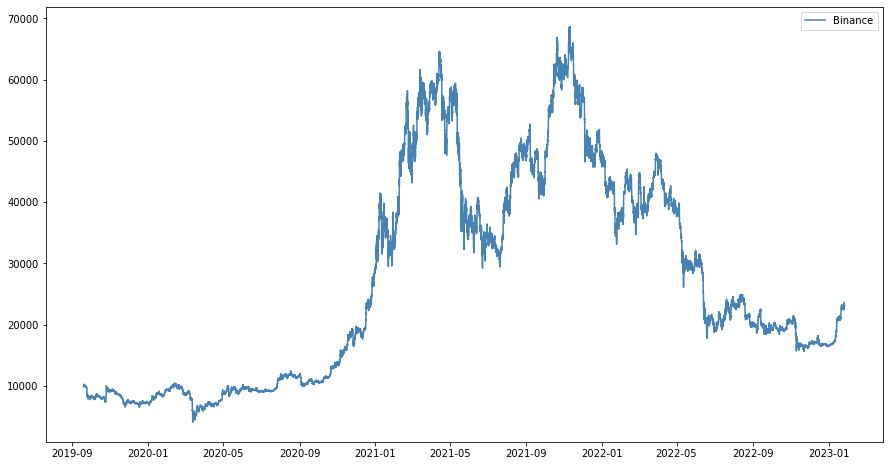

In [ ]:
# зададим размер графика
plt.figure(figsize = (25,8))

#plt.plot(df['Close'], color='red')
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(binance_df['Close'], label='Binance', color='steelblue')
#plt.plot(binance_df['Close'].loc['2010-01-01 00:00:00':], label='Binance', color='blue') -было работало
#plt.plot(graphs2['Close'], label = 'Фактические значения', color = 'steelblue')
#plt.plot(graphs2['predicted_test'], label = 'Предсказания', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
plt.legend(['Binance'])

# добавим подписи к осям и заголовки
plt.ylabel('Цена закрытия', fontsize = 14)
plt.xlabel('Период', fontsize = 14)
plt.title('График фактических значений', fontsize = 16)

# вывод на графике
plt.show()

In [ ]:
display(binance_df.head())
display(binance_df.tail())
display(binance_df.describe())
binance_df.info()

,Open,High,Low,Close,Volume
Time,,,,,
2019-09-19 10:00:00,9881.43,9881.43,9828.59,9849.75,0.056889
2019-09-19 11:00:00,9849.75,9849.75,9849.75,9849.75,0.000000
2019-09-19 12:00:00,9848.41,9858.85,9848.41,9858.85,0.021138
2019-09-19 13:00:00,9870.06,9887.21,9866.53,9866.53,0.012525
2019-09-19 14:00:00,9866.53,9866.53,9866.53,9866.53,0.000000


,Open,High,Low,Close,Volume
Time,,,,,
2023-01-26 07:00:00,23092.41,23100.00,22953.95,22970.62,6493.72399
2023-01-26 08:00:00,22970.96,23051.18,22926.08,23007.71,5653.22401
2023-01-26 09:00:00,23006.11,23040.58,22910.00,22974.63,6503.03443
2023-01-26 10:00:00,22974.64,22999.99,22850.00,22943.60,7910.17115
2023-01-26 11:00:00,22942.17,22980.60,22898.13,22976.00,3539.78587


,Open,High,Low,Close,Volume
count,29367.000000,29367.000000,29367.000000,29367.000000,29367.000000
mean,26923.993767,27067.882597,26771.473840,26924.391090,1187.921891
std,17222.335273,17322.542001,17116.207354,17222.009818,2155.716492
min,4115.930000,4606.300000,1800.000000,4115.940000,0.000000
25%,10116.230000,10157.295000,10075.095000,10118.270000,188.799919
50%,20879.150000,20993.650000,20783.000000,20878.720000,443.609379
75%,41510.945000,41708.525000,41298.625000,41510.080000,1077.453237
max,68639.990000,69020.000000,68462.700000,68629.490000,45322.588850


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29367 entries, 2019-09-19 10:00:00 to 2023-01-26 11:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    29367 non-null  float64
 1   High    29367 non-null  float64
 2   Low     29367 non-null  float64
 3   Close   29367 non-null  float64
 4   Volume  29367 non-null  float64
dtypes: float64(5)
memory usage: 1.3 MB


# Предобработка данных.

In [ ]:
#оставим только столбец Close
df_close = binance_df.drop(binance_df.columns[[0,1,2,4]], axis = 1)
df_close.to_csv('df_close.csv')
df_close.head()

,Close
Time,
2019-09-19 10:00:00,9849.75
2019-09-19 11:00:00,9849.75
2019-09-19 12:00:00,9858.85
2019-09-19 13:00:00,9866.53
2019-09-19 14:00:00,9866.53


In [ ]:
data = df_close.copy()
data.head()

,Close
Time,
2019-09-19 10:00:00,9849.75
2019-09-19 11:00:00,9849.75
2019-09-19 12:00:00,9858.85
2019-09-19 13:00:00,9866.53
2019-09-19 14:00:00,9866.53


# Создание признаков.

In [ ]:
#создадим функцию make_features():

def make_features(data, max_lag, rolling_mean_size):
    #добавим год, месяц, день и день недели
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    #data['rolling_mean'] = data['Close'].shift().rolling(rolling_mean_size).mean() #скользящее среднее 
           
    data['sma'] = tb.SMA(data['Close'], timeperiod=50)  # SMA
    data['ema'] = tb.EMA(data['Close'], timeperiod=50)  # EMA 
    data['rsi'] = tb.RSI(data['Close'], timeperiod=50) # RSI  Индекс относительной силы (RSI)      Нормированный     https://investments101.ru/academy/courses/technical-analysis/lessons/oscillators
    data['RSI'] = tb.RSI(data['Close'], timeperiod=14) / tb.RSI(data['Close'], timeperiod=14).mean()
    data['MA5'] = tb.MA(data['Close'], timeperiod=5) / tb.MA(data['Close'], timeperiod=5).mean()
    data['MA10'] = tb.MA(data['Close'], timeperiod=10) / tb.MA(data['Close'], timeperiod=10).mean()
    data['MA20'] = tb.MA(data['Close'], timeperiod=20) / tb.MA(data['Close'], timeperiod=20).mean()
    data['MA60'] = tb.MA(data['Close'], timeperiod=60) / tb.MA(data['Close'], timeperiod=60).mean()
    data['MA120'] = tb.MA(data['Close'], timeperiod=120) / tb.MA(data['Close'], timeperiod=120).mean()
    data['MACD'] = tb.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)[0] / tb.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)[0].mean()   
    data['BBANDS_U'] = tb.BBANDS(data['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0] / tb.BBANDS(data['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[0].mean()
    data['BBANDS_M'] = tb.BBANDS(data['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1] / tb.BBANDS(data['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[1].mean()
    data['BBANDS_L'] = tb.BBANDS(data['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2] / tb.BBANDS(data['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)[2].mean()
    data['HT_DC'] = tb.HT_DCPERIOD(data['Close']) / tb.HT_DCPERIOD(data['Close']).mean()
    
    indicators = ['sma', 'ema', 'rsi', 'RSI', 'MA5', 'MA10', 'MA20', 'MA60', 'MA120', 'MACD', 'BBANDS_U', 'BBANDS_M', 'BBANDS_L', 'HT_DC']
        
    # отстающие значения    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['Close'].shift(lag)
        
    #for lag in range(1, max_lag + 1):
    #    data['rolling_mean_lag_{}'.format(lag)] = data['rolling_mean'].shift(lag)
      
    for idicator in indicators:
        for ind_lag in range(1, max_lag + 1, int(round(max_lag/num_lag_ind))):  # 1-начало,  max_lag + 1 -макс значение лага для индикатора, "int(round(max_lag/3))" -шаг создания лага а num_lag_ind количество лагов для индикатора
            data['{idicator}_lag_{lag}'.format(lag=ind_lag, idicator=idicator)] = data[idicator].shift(ind_lag)

In [ ]:
make_features(data, max_lag, rolling_mean_size)
display(data.head(), data.tail())
data.shape

<ipython-input-59-de3c5fdcee6c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['{idicator}_lag_{lag}'.format(lag=ind_lag, idicator=idicator)] = data[idicator].shift(ind_lag)


,Close,year,month,day,dayofweek,sma,ema,rsi,RSI,MA5,MA10,MA20,MA60,MA120,MACD,BBANDS_U,BBANDS_M,BBANDS_L,HT_DC,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,sma_lag_1,sma_lag_11,sma_lag_21,sma_lag_31,sma_lag_41,ema_lag_1,ema_lag_11,ema_lag_21,ema_lag_31,ema_lag_41,rsi_lag_1,rsi_lag_11,rsi_lag_21,rsi_lag_31,rsi_lag_41,RSI_lag_1,RSI_lag_11,RSI_lag_21,RSI_lag_31,RSI_lag_41,MA5_lag_1,MA5_lag_11,MA5_lag_21,MA5_lag_31,MA5_lag_41,MA10_lag_1,MA10_lag_11,MA10_lag_21,MA10_lag_31,MA10_lag_41,MA20_lag_1,MA20_lag_11,MA20_lag_21,MA20_lag_31,MA20_lag_41,MA60_lag_1,MA60_lag_11,MA60_lag_21,MA60_lag_31,MA60_lag_41,MA120_lag_1,MA120_lag_11,MA120_lag_21,MA120_lag_31,MA120_lag_41,MACD_lag_1,MACD_lag_11,MACD_lag_21,MACD_lag_31,MACD_lag_41,BBANDS_U_lag_1,BBANDS_U_lag_11,BBANDS_U_lag_21,BBANDS_U_lag_31,BBANDS_U_lag_41,BBANDS_M_lag_1,BBANDS_M_lag_11,BBANDS_M_lag_21,BBANDS_M_lag_31,BBANDS_M_lag_41,BBANDS_L_lag_1,BBANDS_L_lag_11,BBANDS_L_lag_21,BBANDS_L_lag_31,BBANDS_L_lag_41,HT_DC_lag_1,HT_DC_lag_11,HT_DC_lag_21,HT_DC_lag_31,HT_DC_lag_41
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-19 10:00:00,9849.75,2019,9,19,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19 11:00:00,9849.75,2019,9,19,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9849.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19 12:00:00,9858.85,2019,9,19,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9849.75,9849.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19 13:00:00,9866.53,2019,9,19,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9858.85,9849.75,9849.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-19 14:00:00,9866.53,2019,9,19,3,NaN,NaN,NaN,NaN,0.366127,NaN,NaN,NaN,NaN,NaN,0.362823,0.366127,0.369503,NaN,9866.53,9858.85,9849.75,9849.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

,Close,year,month,day,dayofweek,sma,ema,rsi,RSI,MA5,MA10,MA20,MA60,MA120,MACD,BBANDS_U,BBANDS_M,BBANDS_L,HT_DC,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,sma_lag_1,sma_lag_11,sma_lag_21,sma_lag_31,sma_lag_41,ema_lag_1,ema_lag_11,ema_lag_21,ema_lag_31,ema_lag_41,rsi_lag_1,rsi_lag_11,rsi_lag_21,rsi_lag_31,rsi_lag_41,RSI_lag_1,RSI_lag_11,RSI_lag_21,RSI_lag_31,RSI_lag_41,MA5_lag_1,MA5_lag_11,MA5_lag_21,MA5_lag_31,MA5_lag_41,MA10_lag_1,MA10_lag_11,MA10_lag_21,MA10_lag_31,MA10_lag_41,MA20_lag_1,MA20_lag_11,MA20_lag_21,MA20_lag_31,MA20_lag_41,MA60_lag_1,MA60_lag_11,MA60_lag_21,MA60_lag_31,MA60_lag_41,MA120_lag_1,MA120_lag_11,MA120_lag_21,MA120_lag_31,MA120_lag_41,MACD_lag_1,MACD_lag_11,MACD_lag_21,MACD_lag_31,MACD_lag_41,BBANDS_U_lag_1,BBANDS_U_lag_11,BBANDS_U_lag_21,BBANDS_U_lag_31,BBANDS_U_lag_41,BBANDS_M_lag_1,BBANDS_M_lag_11,BBANDS_M_lag_21,BBANDS_M_lag_31,BBANDS_M_lag_41,BBANDS_L_lag_1,BBANDS_L_lag_11,BBANDS_L_lag_21,BBANDS_L_lag_31,BBANDS_L_lag_41,HT_DC_lag_1,HT_DC_lag_11,HT_DC_lag_21,HT_DC_lag_31,HT_DC_lag_41
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-26 07:00:00,22970.62,2023,1,26,3,22857.7224,22889.023896,52.490349,0.999151,0.858176,0.858327,0.851533,0.849351,0.848238,32.050534,0.854600,0.858176,0.861830,0.816393,23091.03,23151.97,23182.41,23139.50,23183.04,23165.75,23243.08,23062.97,22936.54,23596.74,22939.34,22749.15,22727.36,22571.02,22632.30,22578.98,22437.46,22599.16,22696.33,22602.57,22614.64,22610.38,22666.02,22717.70,22717.24,22676.27,22630.00,22646.40,22553.21,22494.75,22654.75,22636.09,22757.84,22904.16,23012.53,23020.98,23000.77,22912.89,22875.47,22933.95,22859.62,22860.73,22968.72,22921.41,22910.34,22858.33,23056.90,23057.27,23099.44,23122.50,22860.7600,22824.7206,22868.4414,22887.3266,22868.1978,22885.693443,22745.810625,22786.640186,22860.689512,22861.041663,53.842405,54.075845,49.815986,50.386266,53.774540,1.077207,1.199354,0.794971,0.723832,0.898567,0.859754,0.843942,0.841764,0.846514,0.850639,0.860652,0.841269,0.840500,0.849349,0.853085,0.850850,0.840775,0.844814,0.851106,0.853411,0.849242,0.847366,0.847822,0.848704,0.848652,0.848138,0.846251,0.842150,0.837114,0.831297,37.394898,-5.463307,-24.422757,-15.004868,2.368102,0.853187,0.844281,0.836349,0.848274,0.844687,0.859754,0.843942,0.841764,0.846514,0.850639,0.866463,0.843596,0.847296,0.844715,0.856719,0.810159,0.734873,0.778837,0.848991,0.852016
2023-01-26 08:00:00,23007.71,2023,1,26,3,22855.8878,22893.678253,52.862403,1.022035,0.857197,0.858591,0.852111,0.849339,0.848331,28.464793,0.854137,0.857197,0.860324,0.826078,22970.62,23091.03,23151.97,23182.41,23139.50,23183.04,23165.75,23243.08,23062.97,22936.54,23596.74,22939.34,22749.15,22727.36,22571.02,22632.30,22578.98,22437.46,22599.16,22696.33,22602.57,22614.64,22610.38,22666.02,22717.70,22717.24,22676.27,22630.00,22646.40,22553.21,22494.75,22654.75,22636.09,22757.84,22904.16,23012.53,23020.98,23000.77,22912.89,22875.47,22933.95,22859.62,22860.73,22968.72,22921.41,22910.34,22858.33,23056.90,23057.27,23099.44,22857.7224,22840.7788,22864.7578,22882.9832,22868.8554,22889.023896,22779.180404,22779.421747,22846.338943,22863.900813,52.490349,60.915423,49.644861,48.311369,54.660135,0.999151,1.497425,0.782246,0.613248,0.984094,0.858176,0.851106,0.840913,0.842668,0.850815,0.858327,0.844961,0.840901,0.847718,0.852384,0.851533,0.842821,0.844199,0.849940,0.853671,0.849351,0.847867,0.847754,0.848452,0.848758,0.848238,0.846646,0.842656,0.837540,0.831933,32.050534,18.468944,-24.648464,-23.014516,1.880087,0.854600,0.868566,0.835277,0.843801,0.844990,0.858176,0.851106,0.840913,0.842668,0.850815,0.861830,0.833269,0.846669,0.84

(29367, 139)

In [ ]:
#удалим Nan
data = data.dropna()
display(data.head(), data.tail())
data.shape

,Close,year,month,day,dayofweek,sma,ema,rsi,RSI,MA5,MA10,MA20,MA60,MA120,MACD,BBANDS_U,BBANDS_M,BBANDS_L,HT_DC,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,sma_lag_1,sma_lag_11,sma_lag_21,sma_lag_31,sma_lag_41,ema_lag_1,ema_lag_11,ema_lag_21,ema_lag_31,ema_lag_41,rsi_lag_1,rsi_lag_11,rsi_lag_21,rsi_lag_31,rsi_lag_41,RSI_lag_1,RSI_lag_11,RSI_lag_21,RSI_lag_31,RSI_lag_41,MA5_lag_1,MA5_lag_11,MA5_lag_21,MA5_lag_31,MA5_lag_41,MA10_lag_1,MA10_lag_11,MA10_lag_21,MA10_lag_31,MA10_lag_41,MA20_lag_1,MA20_lag_11,MA20_lag_21,MA20_lag_31,MA20_lag_41,MA60_lag_1,MA60_lag_11,MA60_lag_21,MA60_lag_31,MA60_lag_41,MA120_lag_1,MA120_lag_11,MA120_lag_21,MA120_lag_31,MA120_lag_41,MACD_lag_1,MACD_lag_11,MACD_lag_21,MACD_lag_31,MACD_lag_41,BBANDS_U_lag_1,BBANDS_U_lag_11,BBANDS_U_lag_21,BBANDS_U_lag_31,BBANDS_U_lag_41,BBANDS_M_lag_1,BBANDS_M_lag_11,BBANDS_M_lag_21,BBANDS_M_lag_31,BBANDS_M_lag_41,BBANDS_L_lag_1,BBANDS_L_lag_11,BBANDS_L_lag_21,BBANDS_L_lag_31,BBANDS_L_lag_41,HT_DC_lag_1,HT_DC_lag_11,HT_DC_lag_21,HT_DC_lag_31,HT_DC_lag_41
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-26 02:00:00,8356.28,2019,9,26,3,8870.6722,8794.716234,36.087701,0.787707,0.311901,0.312535,0.311202,0.334783,0.352314,-36.425376,0.311676,0.311901,0.312131,1.103085,8346.19,8401.51,8436.75,8450.23,8578.78,8490.86,8343.38,8377.11,8377.11,8337.59,8300.00,8399.00,8385.80,8305.28,8345.43,8409.97,8389.01,8238.19,8351.67,8467.46,8511.74,8489.25,8571.53,8653.01,8699.53,8728.04,8499.75,8675.53,8710.81,8586.43,8371.86,8636.55,9482.58,9494.00,9517.05,9528.35,9611.00,9689.24,9695.06,9733.50,9733.50,9718.54,9731.36,9783.10,9717.81,9717.81,9727.17,9692.73,9739.18,9686.25,8897.2716,9173.5650,9486.4082,9762.0316,9884.5958,8812.611591,9007.921615,9327.752653,9681.938726,9853.725316,35.866720,32.259648,31.152118,19.409838,44.549010,0.774724,0.638856,0.570383,0.103217,0.817138,0.313554,0.310004,0.318839,0.337981,0.361618,0.312466,0.310432,0.319841,0.348190,0.361144,0.311408,0.315095,0.333972,0.354621,0.362409,0.335752,0.345088,0.355180,0.363692,0.367224,0.352874,0.358238,0.363804,0.368847,0.370561,-37.607589,-79.956555,-100.085337,-75.262558,-15.280555,0.315908,0.309708,0.321403,0.370733,0.359572,0.313554,0.310004,0.318839,0.337981,0.361618,0.311149,0.310306,0.316221,0.304524,0.363708,1.073453,0.986839,1.172624,1.066135,1.503792
2019-09-26 03:00:00,8389.84,2019,9,26,3,8843.6854,8778.838735,36.826474,0.831991,0.311452,0.312582,0.311272,0.333877,0.351764,-34.209352,0.310565,0.311452,0.312359,1.132399,8356.28,8346.19,8401.51,8436.75,8450.23,8578.78,8490.86,8343.38,8377.11,8377.11,8337.59,8300.00,8399.00,8385.80,8305.28,8345.43,8409.97,8389.01,8238.19,8351.67,8467.46,8511.74,8489.25,8571.53,8653.01,8699.53,8728.04,8499.75,8675.53,8710.81,8586.43,8371.86,8636.55,9482.58,9494.00,9517.05,9528.35,9611.00,9689.24,9695.06,9733.50,9733.50,9718.54,9731.36,9783.10,9717.81,9717.81,9727.17,9692.73,9739.18,8870.6722,9141.8710,9456.6058,9734.0132,9879.0146,8794.716234,8981.634101,9294.015686,9638.977600,9849.010597,36.087701,33.117055,30.663952,26.313968,44.549010,0.787707,0.683298,0.551097,0.369046,0.817138,0.311901,0.309945,0.317116,0.331068,0.361735,0.312535,0.309949,0.319400,0.343930,0.361320,0.311202,0.314633,0.331621,0.352579,0.362059,0.334783,0.344086,0.354240,0.362810,0.367073,0.352314,0.357676,0.363274,0.368331,0.370525,-36.425376,-76.262384,-99.313428,-88.067495,-14.387332,0.311676,0.309664,0.318694,0.362642,0.359560,0.311901,0.309945,0.317116,0.331068,0.361735,0.312131,0.310233,0.315503,0.298815,0.363956,1.103085,0.984367,1.154707,1.046455,1.525846
2019-09-26 04:00:00,8341.19,2019,9,26,3,8816.6546,8761.6

,Close,year,month,day,dayofweek,sma,ema,rsi,RSI,MA5,MA10,MA20,MA60,MA120,MACD,BBANDS_U,BBANDS_M,BBANDS_L,HT_DC,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,sma_lag_1,sma_lag_11,sma_lag_21,sma_lag_31,sma_lag_41,ema_lag_1,ema_lag_11,ema_lag_21,ema_lag_31,ema_lag_41,rsi_lag_1,rsi_lag_11,rsi_lag_21,rsi_lag_31,rsi_lag_41,RSI_lag_1,RSI_lag_11,RSI_lag_21,RSI_lag_31,RSI_lag_41,MA5_lag_1,MA5_lag_11,MA5_lag_21,MA5_lag_31,MA5_lag_41,MA10_lag_1,MA10_lag_11,MA10_lag_21,MA10_lag_31,MA10_lag_41,MA20_lag_1,MA20_lag_11,MA20_lag_21,MA20_lag_31,MA20_lag_41,MA60_lag_1,MA60_lag_11,MA60_lag_21,MA60_lag_31,MA60_lag_41,MA120_lag_1,MA120_lag_11,MA120_lag_21,MA120_lag_31,MA120_lag_41,MACD_lag_1,MACD_lag_11,MACD_lag_21,MACD_lag_31,MACD_lag_41,BBANDS_U_lag_1,BBANDS_U_lag_11,BBANDS_U_lag_21,BBANDS_U_lag_31,BBANDS_U_lag_41,BBANDS_M_lag_1,BBANDS_M_lag_11,BBANDS_M_lag_21,BBANDS_M_lag_31,BBANDS_M_lag_41,BBANDS_L_lag_1,BBANDS_L_lag_11,BBANDS_L_lag_21,BBANDS_L_lag_31,BBANDS_L_lag_41,HT_DC_lag_1,HT_DC_lag_11,HT_DC_lag_21,HT_DC_lag_31,HT_DC_lag_41
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-26 07:00:00,22970.62,2023,1,26,3,22857.7224,22889.023896,52.490349,0.999151,0.858176,0.858327,0.851533,0.849351,0.848238,32.050534,0.854600,0.858176,0.861830,0.816393,23091.03,23151.97,23182.41,23139.50,23183.04,23165.75,23243.08,23062.97,22936.54,23596.74,22939.34,22749.15,22727.36,22571.02,22632.30,22578.98,22437.46,22599.16,22696.33,22602.57,22614.64,22610.38,22666.02,22717.70,22717.24,22676.27,22630.00,22646.40,22553.21,22494.75,22654.75,22636.09,22757.84,22904.16,23012.53,23020.98,23000.77,22912.89,22875.47,22933.95,22859.62,22860.73,22968.72,22921.41,22910.34,22858.33,23056.90,23057.27,23099.44,23122.50,22860.7600,22824.7206,22868.4414,22887.3266,22868.1978,22885.693443,22745.810625,22786.640186,22860.689512,22861.041663,53.842405,54.075845,49.815986,50.386266,53.774540,1.077207,1.199354,0.794971,0.723832,0.898567,0.859754,0.843942,0.841764,0.846514,0.850639,0.860652,0.841269,0.840500,0.849349,0.853085,0.850850,0.840775,0.844814,0.851106,0.853411,0.849242,0.847366,0.847822,0.848704,0.848652,0.848138,0.846251,0.842150,0.837114,0.831297,37.394898,-5.463307,-24.422757,-15.004868,2.368102,0.853187,0.844281,0.836349,0.848274,0.844687,0.859754,0.843942,0.841764,0.846514,0.850639,0.866463,0.843596,0.847296,0.844715,0.856719,0.810159,0.734873,0.778837,0.848991,0.852016
2023-01-26 08:00:00,23007.71,2023,1,26,3,22855.8878,22893.678253,52.862403,1.022035,0.857197,0.858591,0.852111,0.849339,0.848331,28.464793,0.854137,0.857197,0.860324,0.826078,22970.62,23091.03,23151.97,23182.41,23139.50,23183.04,23165.75,23243.08,23062.97,22936.54,23596.74,22939.34,22749.15,22727.36,22571.02,22632.30,22578.98,22437.46,22599.16,22696.33,22602.57,22614.64,22610.38,22666.02,22717.70,22717.24,22676.27,22630.00,22646.40,22553.21,22494.75,22654.75,22636.09,22757.84,22904.16,23012.53,23020.98,23000.77,22912.89,22875.47,22933.95,22859.62,22860.73,22968.72,22921.41,22910.34,22858.33,23056.90,23057.27,23099.44,22857.7224,22840.7788,22864.7578,22882.9832,22868.8554,22889.023896,22779.180404,22779.421747,22846.338943,22863.900813,52.490349,60.915423,49.644861,48.311369,54.660135,0.999151,1.497425,0.782246,0.613248,0.984094,0.858176,0.851106,0.840913,0.842668,0.850815,0.858327,0.844961,0.840901,0.847718,0.852384,0.851533,0.842821,0.844199,0.849940,0.853671,0.849351,0.847867,0.847754,0.848452,0.848758,0.848238,0.846646,0.842656,0.837540,0.831933,32.050534,18.468944,-24.648464,-23.014516,1.880087,0.854600,0.868566,0.835277,0.843801,0.844990,0.858176,0.851106,0.840913,0.842668,0.850815,0.861830,0.833269,0.846669,0.84

(29207, 139)

# Разбивка выборки.

In [ ]:
features = data.drop(['Close'], axis=1) 
target = data['Close']

#Функция train_test_split() из модуля sklearn.model_selection по умолчанию перемешивает данные. 
#Поэтому укажем аргумент shuffle (с англ. «перетасовывать») равным False, чтобы разделить данные корректно.
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=12345)

#убедимся в корректности деления временных диапазонов
print('train', features_train.index.min(), features_train.index.max())
print('test', features_test.index.min(), features_test.index.max())

train 2019-09-26 02:00:00 2022-09-26 18:00:00
test 2022-09-26 19:00:00 2023-01-26 11:00:00


# Создание, обучение модели.

## CatBoostRegressor.

In [ ]:
%%time

#объявим классификатор
model = CatBoostRegressor(random_state=12345)

#создаем словарь, в который вписываем параметры, которые будем прогонять GridSearch’ем
parametrs = {'reg_lambda':[1,3,6],
             'learning_rate':[0.001, 0.01,0.1]                           
            }

tscv = TimeSeriesSplit(n_splits=5, test_size=None)

#запускаем обучение (n_jobs = -1, использовать все ЦП для обучения, по умолчанию 1 - использовать 1 ЦП)
grid = GridSearchCV(model, parametrs, cv=tscv, n_jobs = -1, scoring='neg_root_mean_squared_error', verbose=3)
grid.fit(features_train, target_train)

#выводим лучшие параметры
print(grid.best_params_)
print(grid.best_score_)

model = grid.best_estimator_
dump(model, 'CatBoostRegressor.joblib')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0:	learn: 17715.2081502	total: 113ms	remaining: 1m 53s
1:	learn: 17542.6479108	total: 167ms	remaining: 1m 23s
2:	learn: 17371.2004663	total: 213ms	remaining: 1m 10s
3:	learn: 17201.3379022	total: 261ms	remaining: 1m 5s
4:	learn: 17033.4020578	total: 310ms	remaining: 1m 1s
5:	learn: 16867.4093783	total: 365ms	remaining: 1m
6:	learn: 16703.6590233	total: 413ms	remaining: 58.6s
7:	learn: 16540.9570143	total: 460ms	remaining: 57.1s
8:	learn: 16379.9880635	total: 510ms	remaining: 56.1s
9:	learn: 16220.0098115	total: 561ms	remaining: 55.5s
10:	learn: 16060.9623356	total: 611ms	remaining: 54.9s
11:	learn: 15905.2662643	total: 658ms	remaining: 54.2s
12:	learn: 15750.5368428	total: 704ms	remaining: 53.5s
13:	learn: 15597.7333450	total: 755ms	remaining: 53.1s
14:	learn: 15445.5273809	total: 801ms	remaining: 52.6s
15:	learn: 15294.6811121	total: 853ms	remaining: 52.4s
16:	learn: 15145.4804215	total: 902ms	remaining: 52.1s
17:	learn: 1499

['CatBoostRegressor.joblib']

In [ ]:
# # по окончании операции выше - воспроизвести звук Windows как оповещение.
# import winsound
# for i in range(2):
#     winsound.PlaySound("SystemQuestion", winsound.SND_ALIAS)

# Тестирование модели. RMSE

In [ ]:
%%time
model = joblib.load('CatBoostRegressor.joblib')

predicted_test = model.predict(features_test)
rmse_catboost = (mean_squared_error(target_test, predicted_test))**0.5
print("RMSE =", rmse_catboost) # Среднеквадратичное отклонение (ошибка)
print("RMSE/close, % =", round((rmse_catboost/data['Close'].mean())*100, 2))

RMSE = 243.90978173710675
RMSE/close, % = 0.9
CPU times: user 37.6 ms, sys: 979 µs, total: 38.6 ms
Wall time: 29.8 ms


## График тестовых данных и предсказаний.

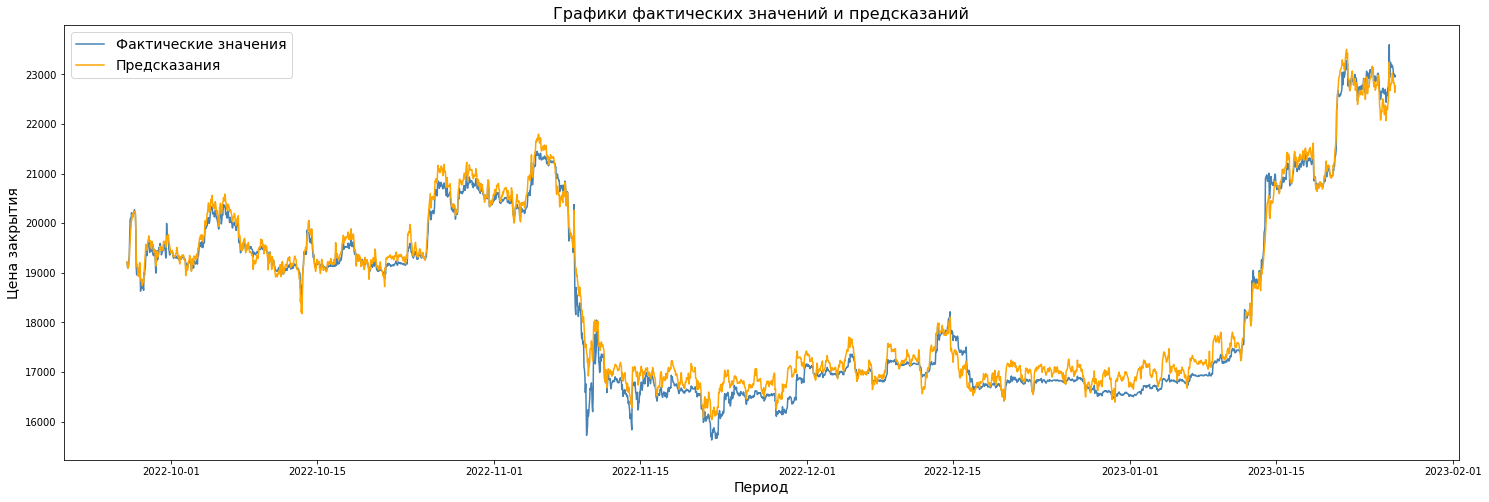

In [ ]:
model = joblib.load('CatBoostRegressor.joblib')
predicted_test = model.predict(features_test)

graphs = pd.DataFrame(target_test)
graphs['predicted_test'] = predicted_test
graphs2 = graphs

# graphs2 = graphs2.loc['2022-10-01 00:00:00':'2022-11-20 00:00:00'] работало
graphs2 = graphs2.loc['2022-05-01 00:00:00':]

# зададим размер графика
plt.figure(figsize = (25,8))
 
# зададим кривые с подписями и цветом
plt.plot(graphs2['Close'], label = 'Фактические значения', color = 'steelblue')
#plt.plot(graphs2['Close'].head(250), label = 'Фактические значения', color = 'steelblue')
plt.plot(graphs2['predicted_test'], label = 'Предсказания', color = 'orange')
 
# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)
 
# добавим подписи к осям и заголовки
plt.ylabel('Цена закрытия', fontsize = 14)
plt.xlabel('Период', fontsize = 14)
plt.title('Графики фактических значений и предсказаний', fontsize = 16)
 
# выведем обе кривые на одном графике
plt.show()

## График важности признаков модели.

0:	learn: 17053.5667464	total: 60.9ms	remaining: 1m
1:	learn: 16887.4305162	total: 124ms	remaining: 1m 1s
2:	learn: 16722.5328892	total: 172ms	remaining: 57.1s
3:	learn: 16560.0082678	total: 230ms	remaining: 57.3s
4:	learn: 16398.2999330	total: 286ms	remaining: 56.9s
5:	learn: 16239.3808869	total: 343ms	remaining: 56.8s
6:	learn: 16081.1074056	total: 391ms	remaining: 55.5s
7:	learn: 15924.6203751	total: 454ms	remaining: 56.3s
8:	learn: 15769.1533984	total: 507ms	remaining: 55.9s
9:	learn: 15616.2012194	total: 557ms	remaining: 55.1s
10:	learn: 15464.5340321	total: 612ms	remaining: 55s
11:	learn: 15314.2430631	total: 660ms	remaining: 54.3s
12:	learn: 15165.2068348	total: 714ms	remaining: 54.2s
13:	learn: 15018.6827843	total: 762ms	remaining: 53.7s
14:	learn: 14873.5256814	total: 811ms	remaining: 53.2s
15:	learn: 14729.6173842	total: 860ms	remaining: 52.9s
16:	learn: 14586.4564134	total: 910ms	remaining: 52.6s
17:	learn: 14443.8999594	total: 963ms	remaining: 52.5s
18:	learn: 14303.0532696

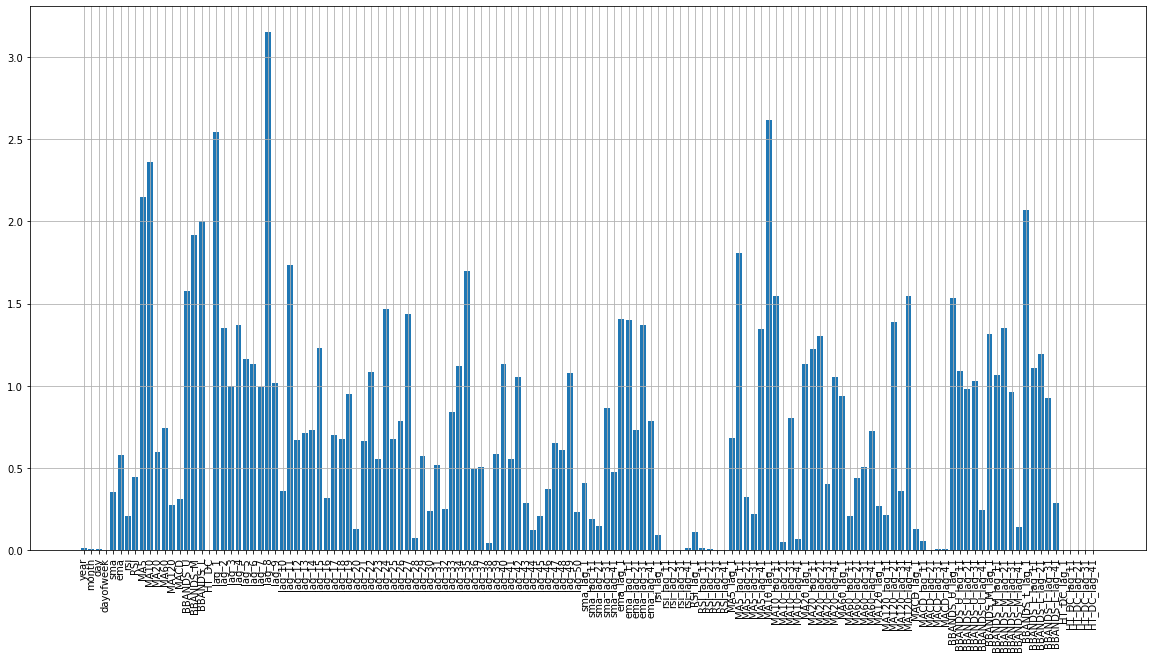

In [ ]:
clf = joblib.load('CatBoostRegressor.joblib')
clf.fit(features, target)
# create a figure to plot a bar, where x axis is features, and Y indicating the importance of each feature
plt.figure(figsize=(20,10))
plt.bar(features.columns, clf.feature_importances_)
plt.xticks(rotation=90)

plt.grid(True)
plt.show()

#  Предсказание изменения тренда фьючерса на заданное количество периодов (временных интервалов свеч) вперед. 
       Создание функции make_prediction

<ipython-input-132-1a78b652b680>:83: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_close['{idicator}_lag_{lag}'.format(lag=ind_lag, idicator=idicator)] = df_close[idicator].shift(ind_lag)


,Close,year,month,day,dayofweek,sma,ema,rsi,RSI,MA5,MA10,MA20,MA60,MA120,MACD,BBANDS_U,BBANDS_M,BBANDS_L,HT_DC,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,sma_lag_1,sma_lag_11,sma_lag_21,sma_lag_31,sma_lag_41,ema_lag_1,ema_lag_11,ema_lag_21,ema_lag_31,ema_lag_41,rsi_lag_1,rsi_lag_11,rsi_lag_21,rsi_lag_31,rsi_lag_41,RSI_lag_1,RSI_lag_11,RSI_lag_21,RSI_lag_31,RSI_lag_41,MA5_lag_1,MA5_lag_11,MA5_lag_21,MA5_lag_31,MA5_lag_41,MA10_lag_1,MA10_lag_11,MA10_lag_21,MA10_lag_31,MA10_lag_41,MA20_lag_1,MA20_lag_11,MA20_lag_21,MA20_lag_31,MA20_lag_41,MA60_lag_1,MA60_lag_11,MA60_lag_21,MA60_lag_31,MA60_lag_41,MA120_lag_1,MA120_lag_11,MA120_lag_21,MA120_lag_31,MA120_lag_41,MACD_lag_1,MACD_lag_11,MACD_lag_21,MACD_lag_31,MACD_lag_41,BBANDS_U_lag_1,BBANDS_U_lag_11,BBANDS_U_lag_21,BBANDS_U_lag_31,BBANDS_U_lag_41,BBANDS_M_lag_1,BBANDS_M_lag_11,BBANDS_M_lag_21,BBANDS_M_lag_31,BBANDS_M_lag_41,BBANDS_L_lag_1,BBANDS_L_lag_11,BBANDS_L_lag_21,BBANDS_L_lag_31,BBANDS_L_lag_41,HT_DC_lag_1,HT_DC_lag_11,HT_DC_lag_21,HT_DC_lag_31,HT_DC_lag_41
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-27 02:00:00,22976.0,2023,1,27,4,22882.5174,22935.236421,52.47585,1.001547,0.853409,0.853353,0.853227,0.849251,0.848327,2.575012,0.844427,0.853409,0.862585,0.985345,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22943.6,22974.63,23007.71,22970.62,23091.03,23151.97,23182.41,23139.50,23183.04,23165.75,23243.08,23062.97,22936.54,23596.74,22939.34,22749.15,22727.36,22571.02,22632.30,22578.98,22437.46,22599.16,22696.33,22602.57,22614.64,22610.38,22666.02,22717.70,22717.24,22676.27,22630.00,22646.40,22553.21,22494.75,22654.75,22876.0924,22859.1784,22860.4778,22824.6498,22870.6000,22933.572602,22912.702383,22877.312359,22737.911466,22793.660601,52.47585,52.47585,54.539176,51.678397,49.756082,1.001547,1.001547,1.118261,1.042915,0.788651,0.853409,0.853409,0.860412,0.841366,0.842323,0.853353,0.853753,0.860192,0.840164,0.840750,0.853441,0.856860,0.850066,0.840347,0.845370,0.849180,0.849286,0.849251,0.847336,0.847968,0.848245,0.848471,0.848100,0.846156,0.841744,2.885661,10.063543,39.537347,-14.015010,-24.102079,0.844427,0.844427,0.852607,0.837951,0.836366,0.853409,0.853409,0.860412,0.841366,0.842323,0.862585,0.862585,0.868386,0.844855,0.848408,0.984793,0.968573,0.802026,0.743216,0.786166
2023-01-27 03:00:00,22976.0,2023,1,27,4,22892.1424,22936.834993,52.47585,1.001547,0.853409,0.853353,0.853237,0.849278,0.848393,2.302281,0.844427,0.853409,0.862585,0.987176,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22976.0,22943.60,22974.63,23007.71,22970.62,23091.03,23151.97,23182.41,23139.50,23183.04,23165.75,23243.08,23062.97,22936.54,23596.74,22939.34,22749.15,22727.36,22571.02,22632.30,22578.98,22437.46,22599.16,22696.33,22602.57,22614.64,22610.38,22666.02,22717.70,22717.24,22676.27,22630.00,22646.40,22553.21,22494.75,22882.5174,22861.5060,22860.7600,22824.7206,22868.4414,22935.236421,22915.184642,22885.693443,22745.810625,22786.640186,52.47585,52.47585,53.842405,54.075845,49.815986,1.001547,1.001547,1.077206,1.199352,0.794970,0.853409,0.853409,0.859857,0.844043,0.841865,0.853353,0.853325,0.860755,0.841370,0.840601,0.853227,0.856928,0.850951,0.840875,0.844915,0.849251,0.849224,0.849347,0.847470,0.847926,0.848327,0.848401,0.848243,0.846357,0.842255,2.575012,8.803088,37.272918,-5.445486,-24.343091,0.844427,0.844427,0.853295,0.844388,0.836456,0.853409,0.853409,0.859857,0.844043,0.841865,0.862585,0.862585,0.866560,0.843691,0.847391,0.985345,0.980878,0.810171,0.7

'predicted Close'

Time
2023-01-26 12:00:00    22976.000000
2023-01-26 13:00:00    22942.950077
2023-01-26 14:00:00    22963.585331
2023-01-26 15:00:00    22893.407798
2023-01-26 16:00:00    22982.432413
Name: predicted_test, dtype: float64

'max predicted Close'

Time
2023-01-26 18:00:00    23133.404987
Name: predicted_test, dtype: float64

'min predicted Close'

Time
2023-01-26 15:00:00    22893.407798
Name: predicted_test, dtype: float64

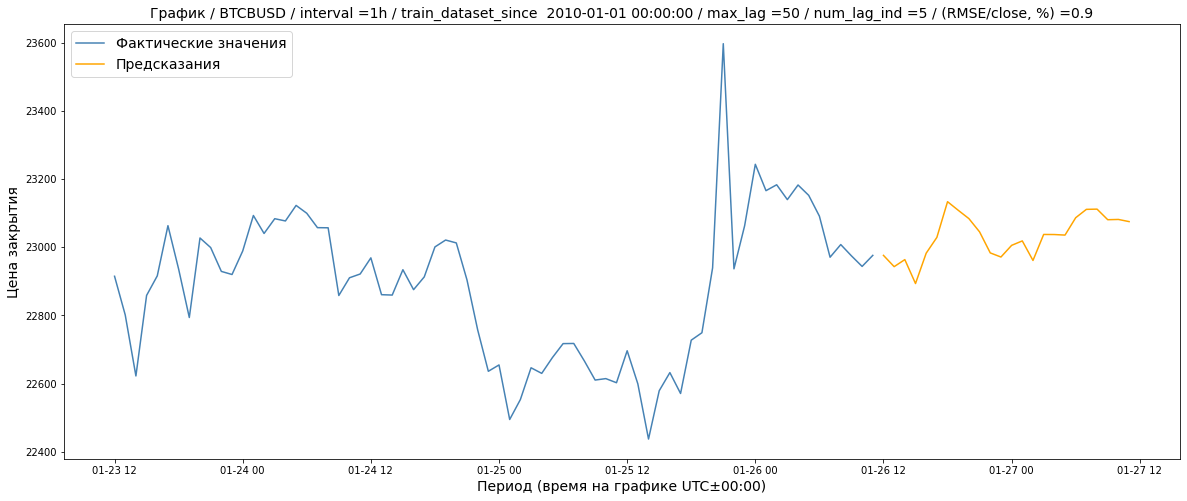

In [ ]:
symbol = symbol
from crypto_functions import make_prediction
df_close = make_prediction(1, 24, max_lag, rolling_mean_size) 

# Вывод

    Создана и обучена регрессионная модель на основе CatBoost, точность при тестировании: RMSE = 243.9 , RMSE/close, % = 0.9.
    Время обучения на данных с 2019-09-19, 29367 объектов/строк -32минуты.
    Пример прогноза и фактических данных на скринах ниже. Данные предсказаний сильно растянуты по оси X и запаздывают: первый предсказанный пик смещен вправо на ~6часов, но при этом на предсказанных данных мы видим 2 пика аналогичных по форме и по величине (по оси Y) как на фактических данных.


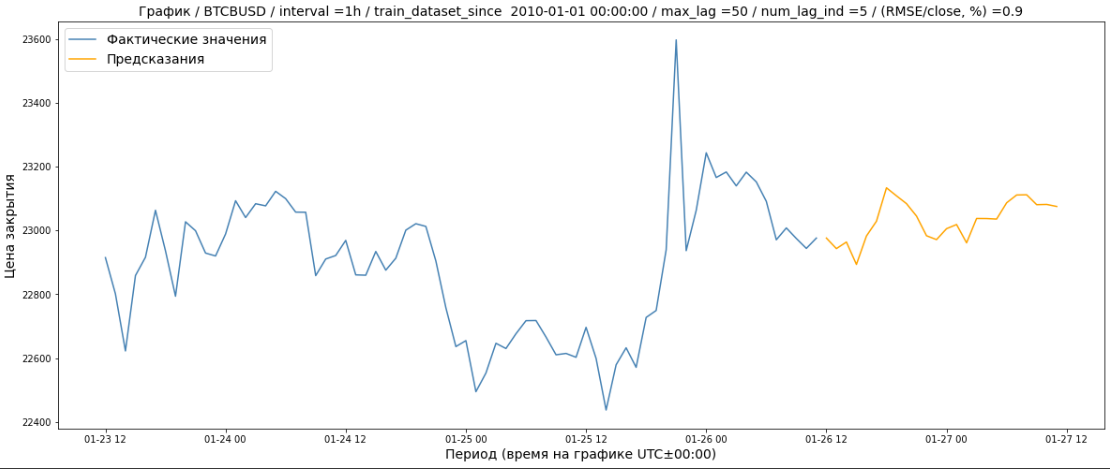

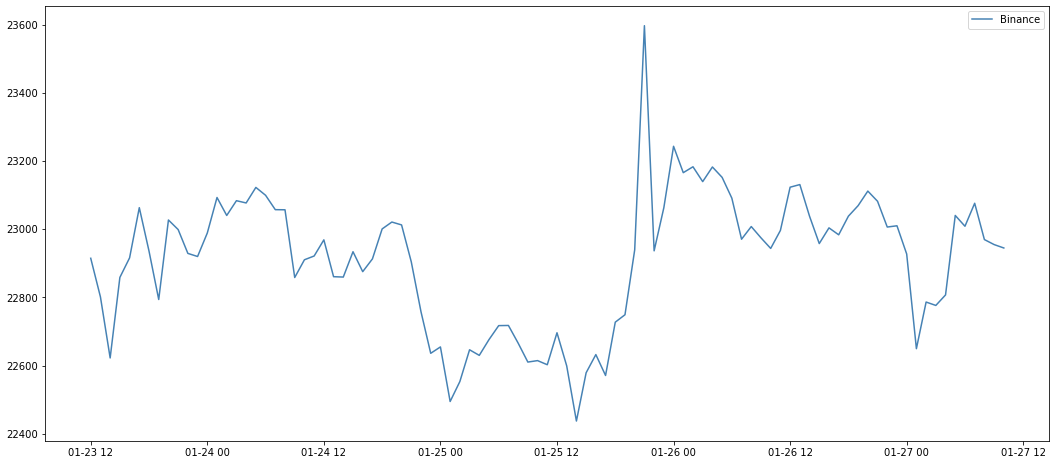